# HW4 : Neural Networks, L-BFGS and SGD

This is the starter notebook for HW4, specific to Problems 1 and 2 only.

### Instructions

The authoritative HW4 instructions are on the course website:

http://www.cs.tufts.edu/comp/135/2025s/hw4.html

Please report any questions to Piazza.

We've tried to make random seeds set explicitly so you can reproduce these exact results, but remember that some differences across platforms might occur, so the exact count of how many runs "converge" or not may not be precise (though hopefully in the same ballpark).

### Outline of this Notebook

* [Problem 1: MLP with LBFGS](#part1): How many hidden units should we pick?
* [Problem 2: MLP with SGD](#part2): What batch size and learning rate should we pick?

Note: 

* You **only** need to do coding/analysis tasks for Problem 1
* Problem 2 code here is provided for your own learning, but you should use the provided figure on the HW4 instructions website.

In [1]:
import os
import numpy as np
import pandas as pd
import time
import warnings

from sklearn.neural_network import MLPClassifier
import sklearn.metrics

In [2]:
# import plotting libraries
import matplotlib
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8') # pretty matplotlib plots

import seaborn as sns
sns.set('notebook', font_scale=1.25, style='whitegrid')

In [3]:
# Used for some bonus visualizations

from viz_tools_for_binary_classifier import plot_pretty_probabilities_for_clf

# Load the "Flower XOR" dataset

This is a challenging binary classification task. 

10,000 labeled examples in training set

Each example has 2 features ($x_{n1}, x_{n2}$)

Each label is binary (0 or 1)

Clearly, a simple logistic regression would not do well here (no linear decision boundary would work).

In [4]:
DATA_DIR = "data_flower" # TODO as needed, fix to valid path on your local system

In [5]:
# Load training data
x_tr_N2 = np.loadtxt(os.path.join(DATA_DIR, 'x_train.csv'), skiprows=1, delimiter=',')
y_tr_N = np.loadtxt(os.path.join(DATA_DIR, 'y_train.csv'), skiprows=1, delimiter=',')

# Load test data
x_te_T2 = np.loadtxt(os.path.join(DATA_DIR, 'x_test.csv'), skiprows=1, delimiter=',')
y_te_T = np.loadtxt(os.path.join(DATA_DIR, 'y_test.csv'), skiprows=1, delimiter=',')

N = y_tr_N.size
assert x_tr_N2.shape[0] == y_tr_N.shape[0]
assert x_te_T2.shape[0] == y_te_T.shape[0]

print("x_tr shape", x_tr_N2.shape)
print("y_tr shape", y_tr_N.shape)

x_tr shape (10000, 2)
y_tr shape (10000,)


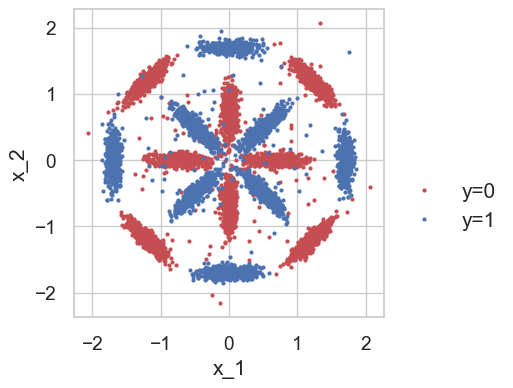

In [6]:
fig, _ = plt.subplots(figsize=(4,4));
plt.plot(x_tr_N2[y_tr_N == 0,0], x_tr_N2[y_tr_N == 0,1], 'r.', label='y=0');
plt.plot(x_tr_N2[y_tr_N == 1,0], x_tr_N2[y_tr_N == 1,1], 'b.', label='y=1');
plt.legend(bbox_to_anchor=[1.0, 0.5], fontsize=15);
plt.xlabel('x_1'); plt.ylabel('x_2');

<a id="problem1"></a>

# Problem 1: MLP with L-BFGS solver - What model size is best?

Let's train an MLP at each of several different sizes.

For this problem, we'll use the `solver='lbfgs'`

We'll try multiple runs of the optimizer, to see what the impact of different random initializations of parameters is.

In [7]:
size_list = [4, 16, 64, 256]
n_runs = 4

S = len(size_list)

tr_loss_arr = 0.11 * np.ones((S, n_runs)) # Pre allocate with arbitrary values, just so code doesnt break
te_loss_arr = 0.22 * np.ones((S, n_runs))

tr_err_arr = 0.08 * np.ones((S, n_runs))
te_err_arr = 0.13 * np.ones((S, n_runs))

## TODO: Complete Step 1A below

In [10]:
max_iter_per_run = 1000

for size in size_list: # TODO loop over all sizes in size_list, not just 4 hidden layers
    size_id = size_list.index(size)
    for run_id in range(n_runs):
        
        start_time_sec = time.time()
        mlp = MLPClassifier(
            hidden_layer_sizes=[size], # create one hidden layer, of specified size
            random_state=int(run_id),  # force the initialization to use current seed 
            max_iter=max_iter_per_run,
            activation='relu',
            alpha=0.0001,
            solver='lbfgs', 
            tol=1e-5,
            batch_size=N,
            )
        # Call fit on training data
        # This `with ...` block avoids warnings about 'did not converge'
        # You can feel free to ignore such warnings (as done here) to save time
        with warnings.catch_warnings(record=True) as warn_list:
            mlp.fit(x_tr_N2, y_tr_N)
        elapsed_time_sec = time.time() - start_time_sec
        mlp.did_converge = True if len(warn_list) == 0 else False

        # TODO compute the log loss on training set and test set
        # Can use code like this:
        #      sklearn.metrics.log_loss(..., ...) / np.log(2)
        # Remember we divide to convert to base-2, so that it is an upper bound on error rate
        pred_tr = mlp.predict_proba(x_tr_N2)
        pred_te = mlp.predict_proba(x_te_T2)
        pred_tr2 = mlp.predict(x_tr_N2)
        pred_te2 = mlp.predict(x_te_T2)
        tr_log_loss = sklearn.metrics.log_loss(y_tr_N, pred_tr) / np.log(2)  # TODO fixme
        te_log_loss = sklearn.metrics.log_loss(y_te_T, pred_te) / np.log(2)  # TODO fixme
        
        # TODO compute the error rate on the training set and test set
        # Can use code like this:
        #      sklearn.metrics.zero_one_loss(..., ...)
        tr_err = sklearn.metrics.zero_one_loss(y_tr_N, pred_tr2) # TODO fixme
        te_err = sklearn.metrics.zero_one_loss(y_te_T, pred_te2) # TODO fixme
        
        # TODO store this mlp's performance so you can plot it later
        # You can use the provided `tr_loss_arr', or find another way that makes sense to you
        tr_loss_arr[size_id, run_id] =  tr_log_loss
        te_loss_arr[size_id, run_id] = te_log_loss

        tr_err_arr[size_id, run_id] = tr_err
        te_err_arr[size_id, run_id] = te_err
        print(
            'layer_sizes %3d: run %d/%d done after %5.1f sec | %13s after %3d iter | tr err %.3f | te err %.3f' % (
            size, 
            run_id + 1, n_runs, elapsed_time_sec,
            'yes converged' if mlp.did_converge else 'NOT converged',
            max_iter_per_run,
            tr_err, te_err))

layer_sizes   4: run 1/4 done after   0.9 sec | yes converged after 1000 iter | tr err 0.259 | te err 0.265
layer_sizes   4: run 2/4 done after   0.1 sec | yes converged after 1000 iter | tr err 0.300 | te err 0.303
layer_sizes   4: run 3/4 done after   0.1 sec | yes converged after 1000 iter | tr err 0.359 | te err 0.358
layer_sizes   4: run 4/4 done after   0.2 sec | yes converged after 1000 iter | tr err 0.213 | te err 0.210
layer_sizes  16: run 1/4 done after   2.6 sec | yes converged after 1000 iter | tr err 0.016 | te err 0.016
layer_sizes  16: run 2/4 done after   3.3 sec | NOT converged after 1000 iter | tr err 0.018 | te err 0.022
layer_sizes  16: run 3/4 done after   1.4 sec | yes converged after 1000 iter | tr err 0.021 | te err 0.024
layer_sizes  16: run 4/4 done after   3.2 sec | NOT converged after 1000 iter | tr err 0.039 | te err 0.043
layer_sizes  64: run 1/4 done after   8.7 sec | NOT converged after 1000 iter | tr err 0.009 | te err 0.015
layer_sizes  64: run 2/4 don

## For fun and understanding, visualize the latest run's learned MLP

Can you understand why the provided architecture yields the provided decision boundaries?

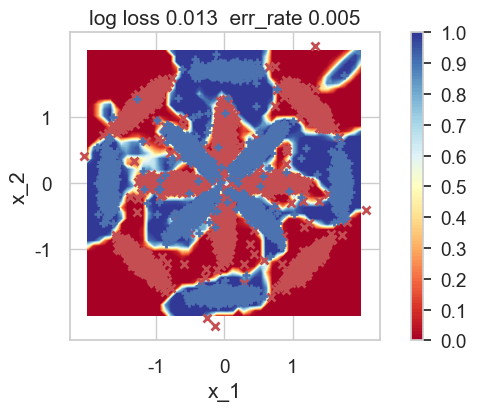

In [12]:
fig, ax_handle = plt.subplots(nrows=1, ncols=1, figsize=(4, 4));
plot_pretty_probabilities_for_clf(mlp, x_tr_N2, y_tr_N, ax=ax_handle, do_show_colorbar=True);
plt.xlabel('x_1'); plt.ylabel('x_2');

## Figure 1 (left): Log loss vs size

TODO if you've filled in the `tr_loss_arr` and `te_loss_arr` correctly so it has shape (S,R) with S sizes and R runs, this code should make a nice plot for you.

Each dot in the plot represents one completed run of the optimizer from a random initialization.


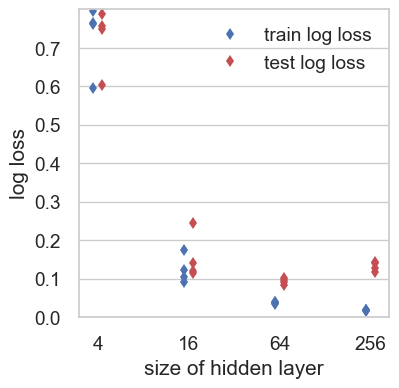

In [13]:
fig, loss_ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 4), sharex=True, sharey=True)

for run_id in range(n_runs):
    tr_label = 'train log loss' if run_id == 0 else ''
    te_label = 'test log loss' if run_id == 0 else ''
    
    jitter = 0.1 # intentially offset the test from train for easier inspection
    loss_ax.plot(np.log2(size_list) - jitter, tr_loss_arr[:,run_id], 'bd', label=tr_label)
    loss_ax.plot(np.log2(size_list) + jitter, te_loss_arr[:,run_id], 'rd', label=te_label)

loss_ax.set_xticks(np.log2(size_list));
loss_ax.set_xticklabels(size_list);
loss_ax.xaxis.grid(False);

loss_ax.set_ylim([0, 0.8]); # Don't touch this please
loss_ax.set_yticks(np.arange(0, 0.8, 0.1));

loss_ax.set_ylabel('log loss');
loss_ax.set_xlabel('size of hidden layer');
loss_ax.legend(loc='upper right');

## Figure 1 (right): Error vs size

TODO if you've filled in the `tr_err_arr` and `te_err_arr` correctly so it has shape (S,R) with S sizes and R runs, this code should make a nice plot for you.


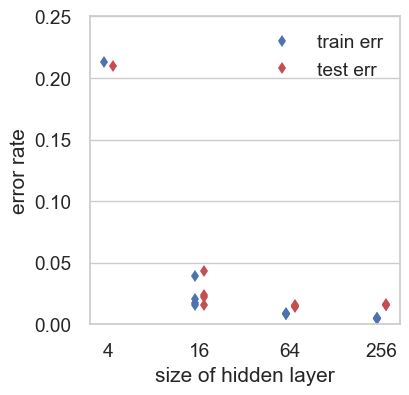

In [15]:
fig, err_ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 4), sharex=True, sharey=True)

for run_id in range(n_runs):
    tr_label = 'train err' if run_id == 0 else ''
    te_label = 'test err' if run_id == 0 else ''
    
    jitter = 0.1 # intentially offset the test from train for easier inspection
    err_ax.plot(np.log2(size_list) - jitter, tr_err_arr[:,run_id], 'bd', label=tr_label)
    err_ax.plot(np.log2(size_list) + jitter, te_err_arr[:,run_id], 'rd', label=te_label)

err_ax.set_xticks(np.log2(size_list));
err_ax.set_xticklabels(size_list);
err_ax.xaxis.grid(False);

err_ax.set_ylim([0, 0.25]); # Don't touch this please

err_ax.set_ylabel('error rate');
err_ax.set_xlabel('size of hidden layer');
err_ax.legend(loc='upper right');

<a id="problem2"></a>

# OPTIONAL material for Problem 2: MLP with SGD : Your own re-implementation

You can stop here if you choose. None of the material below is needed for HW4 in 2025s.

For the required material in the report, see the HW4 instructions page, where you interpret an *already-made* figure provided on the website.

Below is a challenge exercise for your own learning. Not evaluated. 

Can you reproduce the figure you analyzed in Problem 2?



### Goal of this problem: Can we become more scalable with SGD?

There are N=10000 training examples in our training set. Can we use SGD to train our model faster?

We'll fix our model size to 64 hidden units.

Let's try out classic "sgd" (stochastic gradient descent), at a few different batch sizes and learning rates.

Remember, what happens in SGD is given by the pseudocode on the [HW4 Instructions page background section on SGD](https://www.cs.tufts.edu/cs/135/2025s/hw4.html#SGD)

### Vocabulary: What is an iteration in SGD?

Sometimes this word means different things in different contexts. We'll focus on what it means using sklearn's implementation.

Each *iteration* (also called an *epoch*) represents one or more gradient computation and parameter update steps (see pseudocode above).

Each iteration is complete when the number of examples it has ``seen'' (and used for updates) is equal to (or slightly bigger than) the total number examples in the entire training dataset. This number is denoted as N in our code above.

Thus, the number of parameter updates that happen per iteration depends on the `batch_size`.

# Setup: Helper code for plotting training loss as more data is seen.

The second argument 'x' can be adjusted by user so you plot loss versus *time* or loss versus *epochs*

In [12]:
def pretty_plot_loss_curve_vs_x(mlp_list_by_lr, x='elapsed_time_sec', xlim_max=65, ylim_max=0.5):
    ''' Create pretty plot of loss as more data is seen.

    Args
    ----
    mlp_list_by_lr : dict of lists
        Each key is a learning rate.
        Each value is a list of MLPClassifier objects
    x : str
        Either 'elapsed_time_sec' or 'epoch'
        
    Post Condition
    --------------
    Creates new matplotlib figure and plots a line:
    * loss on y-axis
    * the specified x variable on x-axis
    '''

    ncols = len(mlp_list_by_lr)
    fig, ax = plt.subplots(
        nrows=1, ncols=ncols, figsize=(ncols*4, 4),
        squeeze=False,
        sharex=True, sharey=True)
    ax = ax.flatten()
    for ii, (lr, mlp_list) in enumerate(mlp_list_by_lr.items()):
        for mlp in mlp_list:
            if x.count("time"):
                ax[ii].plot(
                    mlp.elapsed_time_sec_ * np.linspace(1.0/mlp.n_iter_, 1.0, mlp.n_iter_),
                    mlp.loss_curve_ / np.log(2.0), '-')
                ax[ii].set_xlabel('elapsed time (sec)');
            else:
                ax[ii].plot(
                    np.arange(mlp.n_iter_),
                    mlp.loss_curve_ / np.log(2.0), '-')
                ax[ii].set_xlabel('epochs completed');

        ax[ii].set_title('lr %.3f \n batch_size %d' % (lr, mlp.batch_size))

        if ii == 0:
            ax[ii].set_ylabel('log loss');
        ax[ii].set_ylim([0.0, ylim_max]);
        ax[ii].set_xlim([0.0, xlim_max]);

## Optional: Reproduce Figure 2 

### Step 1: Try with batch_size = 10000 (each batch sees 100% of the dataset)

We expect each separate "run" will take between 1-3 minutes.

We want you to try at least 2 runs at each of 4 learning rates.

So this block may take ~10-20 minutes to run.

In [13]:
layer_sizes = [16] # TODO FIXME. See instructions
n_runs = 1         # TODO FIXME
lr_list = [0.10]   # TODO FIXME

In [14]:
batch_size = 10000

max_iter_per_run = 20 # Uncomment below if you really want a serious experiment
#max_iter_per_run = 8000 # Don't touch. Has been set so wallclock times are comparable.

mlp_list_by_lr_10000 = dict()

for lr in lr_list:
    mlp_list_by_lr_10000[lr] = list()
        
    for run_id, random_state in enumerate(range(n_runs)):

        start_time_sec = time.time()
        mlp = MLPClassifier(
            hidden_layer_sizes=layer_sizes,
            activation='relu',
            alpha=0.0001,
            random_state=random_state, # controls random init of weights
            max_iter=max_iter_per_run,
            solver='sgd',
            batch_size=batch_size,
            learning_rate='adaptive', learning_rate_init=lr, momentum=0.0,
            tol=1e-5,
            n_iter_no_change=50,
            )
        with warnings.catch_warnings(record=True) as warn_list:
            mlp.fit(x_tr_N2, y_tr_N)
        mlp.elapsed_time_sec_ = time.time() - start_time_sec
        mlp.n_epoch_ = len(mlp.loss_curve_)
        mlp.did_converge = True if len(warn_list) == 0 else False

        # Add to the list
        mlp_list_by_lr_10000[lr].append(mlp)
        
        # Pretty print summary of this run
        msg = 'finished run %2d/%d after %5.1f sec | %13s after %4d iter | tr loss % .3f | lr = %.3f' % (
            run_id + 1, n_runs,
            mlp.elapsed_time_sec_,
            'yes converged' if mlp.did_converge else 'NOT converged',
            mlp.n_epoch_,
            mlp.loss_ / np.log(2.0),
            lr)
        mlp.msg = msg
        print(msg)

finished run  1/1 after   0.1 sec | NOT converged after   20 iter | tr loss  1.017 | lr = 0.100


### Plot loss trace versus elapsed time

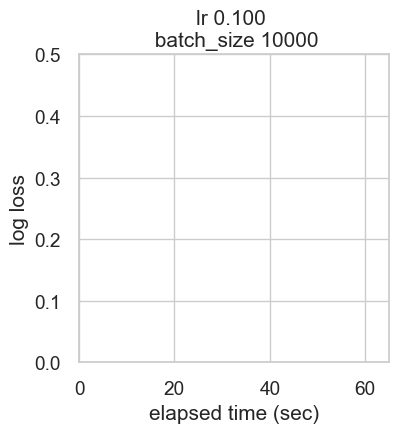

In [15]:
pretty_plot_loss_curve_vs_x(mlp_list_by_lr_10000, x='elapsed_time_sec', xlim_max=65, ylim_max=0.5);


### OPTIONAL step 2: Try with batch_size = 500 (each batch sees ~5% of the dataset)

We expect each separate "run" will take between 1-3 minutes.

We want you to try at least 2 runs at each of 4 learning rates.

So this block may take ~10-20 minutes to run.

In [16]:
batch_size = 500

max_iter_per_run = 20 # Uncomment below if you really want a serious experiment
#max_iter_per_run = 2000 # Don't touch. Has been set so wallclock times are comparable.

mlp_list_by_lr_500 = dict()
for lr in lr_list:
    mlp_list_by_lr_500[lr] = list()
    for run_id, random_state in enumerate(range(n_runs)):
        start_time_sec = time.time()
        mlp = MLPClassifier(
            hidden_layer_sizes=layer_sizes,
            activation='relu',
            alpha=0.0001,
            random_state=random_state, # controls random init of weights
            max_iter=max_iter_per_run,
            solver='sgd',
            batch_size=batch_size,
            learning_rate='adaptive', learning_rate_init=lr, momentum=0.0,
            tol=1e-5,
            n_iter_no_change=50,
            )

        with warnings.catch_warnings(record=True) as warn_list:
            mlp.fit(x_tr_N2, y_tr_N)
        mlp.elapsed_time_sec_ = time.time() - start_time_sec
        mlp.n_epoch_ = len(mlp.loss_curve_)
        mlp.did_converge = True if len(warn_list) == 0 else False

        # Add to the list
        mlp_list_by_lr_500[lr].append(mlp)
        
        # Pretty print summary of this run
        print('finished run %2d/%d after %5.1f sec | %13s after %4d iter | tr loss % .3f | lr = %.3f' % (
            run_id + 1, n_runs,
            mlp.elapsed_time_sec_,
            'yes converged' if mlp.did_converge else 'NOT converged',
            mlp.n_epoch_,
            mlp.loss_ / np.log(2.0),
            lr))

finished run  1/1 after   0.1 sec | NOT converged after   20 iter | tr loss  0.951 | lr = 0.100


### Plot loss trace versus elapsed time

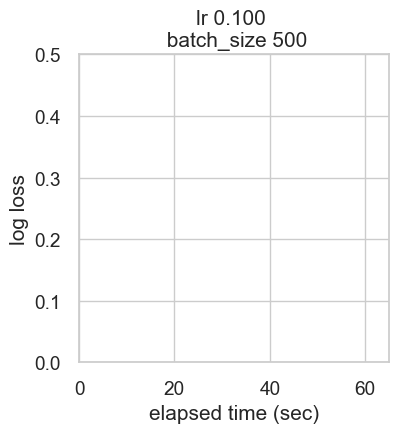

In [17]:
pretty_plot_loss_curve_vs_x(mlp_list_by_lr_500, x='elapsed_time_sec', xlim_max=65, ylim_max=0.5);


## OPTIONAL step 2c: Try with batch_size = 25 (tiny! each batch sees ~0.2% of the dataset)

We expect each separate "run" will take between 1-3 minutes.

We want you to try at least 2 runs at each of 4 learning rates.

So this block may take ~10-20 minutes to run.

In [18]:
batch_size = 25

max_iter_per_run = 20
# max_iter_per_run = 500 # Don't touch. Has been set so wallclock times are comparable.

mlp_list_by_lr_25 = dict()
for lr in lr_list:
    mlp_list_by_lr_25[lr] = list()
    for run_id, random_state in enumerate(range(n_runs)):
        start_time_sec = time.time()
        mlp = MLPClassifier(
            hidden_layer_sizes=layer_sizes,
            activation='relu',
            alpha=0.0001,
            random_state=random_state, # controls random init of weights
            max_iter=max_iter_per_run,
            solver='sgd',
            batch_size=batch_size,
            learning_rate='adaptive', learning_rate_init=lr, momentum=0.0,
            tol=1e-5,
            n_iter_no_change=50,
            )

        with warnings.catch_warnings(record=True) as warn_list:
            mlp.fit(x_tr_N2, y_tr_N)
        mlp.elapsed_time_sec_ = time.time() - start_time_sec
        mlp.n_epoch_ = len(mlp.loss_curve_)
        mlp.did_converge = True if len(warn_list) == 0 else False

        # Add to the list
        mlp_list_by_lr_25[lr].append(mlp)
        
        # Pretty print summary of this run
        print('finished run %2d/%d after %5.1f sec | %13s after %4d iter | tr loss % .3f | lr = %.3f' % (
            run_id + 1, n_runs,
            mlp.elapsed_time_sec_,
            'yes converged' if mlp.did_converge else 'NOT converged',
            mlp.n_epoch_,
            mlp.loss_ / np.log(2.0),
            lr))

finished run  1/1 after   1.1 sec | NOT converged after   20 iter | tr loss  0.396 | lr = 0.100


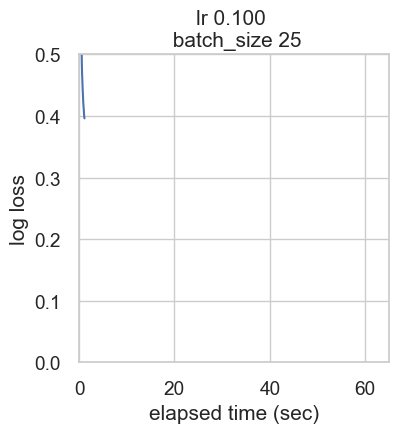

In [19]:
pretty_plot_loss_curve_vs_x(mlp_list_by_lr_25, x='elapsed_time_sec', xlim_max=65, ylim_max=0.5);
